# Analysis Trump/Clinton Tweets - 2016

### Objective: Use statistics, some time series and machine learning to characterize 'tweeter speech' from Donald Trump/Hillary Clinton 

Analysis keypoints:
 1. Use tweepy to download the tweets authored by Donald Trump.
 2. Analysis of Hashtag frequency - What can we learn?
 3. Time series analysis - Number of tweets/correlation - Locate peaks
 4. Word histogram - What are the words more frequently used by either candidate? What can we learn?
 5. But... humans are biased, are they not? Can we do better? Use machine learning!
 6. What about unsupervised learning? Does a predictive model make sense?

In [1]:
#Import the data. The tweets were downloaded using Tweepy.
import json, glob
import datetime
import pandas as pd

In [90]:
dt_tweets_json = []
hc_tweets_json = []
for fn in glob.glob('data/*'):
    with open(fn, 'r') as f:
        if 'Clinton' in fn:
            for line in f:
                hc_tweets_json.append(json.loads(line))
        else:
            for line in f:
                dt_tweets_json.append(json.loads(line))

df_dt = pd.DataFrame(dt_tweets_json).drop_duplicates(subset='id_str', keep='last')
df_dt = df_dt.set_index('id_str', inplace=False)
df_hc = pd.DataFrame(hc_tweets_json).drop_duplicates(subset='id_str', keep='last')
df_hc = df_hc.set_index('id_str', inplace=False)

In [91]:
to_datetime = lambda x: datetime.datetime.strptime(x, "%a %b %d %H:%M:%S +0000 %Y")
df_dt['created_at'] = df_dt['created_at'].apply(to_datetime)
df_hc['created_at'] = df_hc['created_at'].apply(to_datetime)

## 2. Temporal analysis - Who tweets the most?

In [92]:
#Extract number of tweets per date, create dictionaries with information.
from collections import Counter

hc_tweets_per_day = Counter([x.date() for x in df_hc.created_at if x.year > 2015])
dt_tweets_per_day = Counter([x.date() for x in df_dt.created_at if x.year > 2015])
hc_tweets_per_day_noRT = Counter([x.date() for x in df_hc[['RT ' not in x for x in df_hc.text.values]].created_at if x.year > 2015])
dt_tweets_per_day_noRT = Counter([x.date() for x in df_dt[['RT ' not in x for x in df_dt.text.values]].created_at if x.year > 2015])
hc_tweets_per_day_only_RT = Counter([x.date() for x in df_hc[['RT ' in x for x in df_hc.text.values]].created_at if x.year > 2015])
dt_tweets_per_day_only_RT = Counter([x.date() for x in df_dt[['RT ' in x for x in df_dt.text.values]].created_at if x.year > 2015])
#dt_tweets_per_day = Counter([x.date() for x in dt_tweets_json if to_datetime(x).year > 2015])

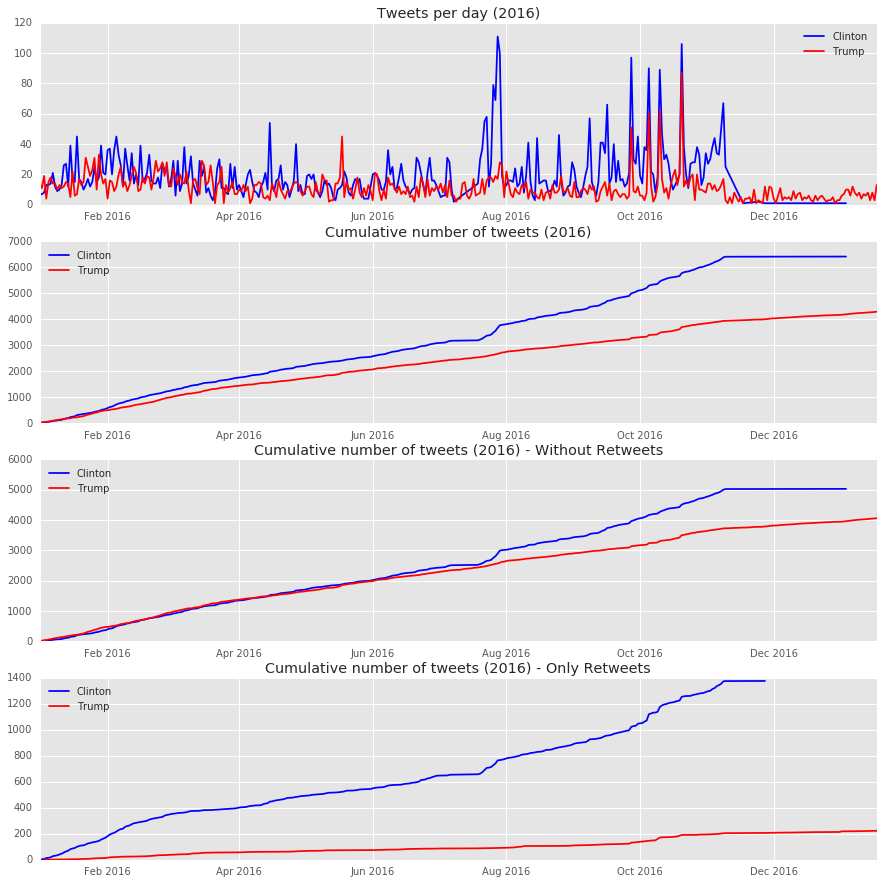

In [93]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
%matplotlib inline
import seaborn as sns

plt.figure(figsize=(15,15))
plt.subplot(4, 1, 1)
pd.Series(hc_tweets_per_day).plot(title = 'Tweets per day (2016)', label = 'Clinton', color = 'b')
pd.Series(dt_tweets_per_day).plot(label = 'Trump', color = 'r')
plt.legend()

plt.subplot(4, 1, 2)
pd.Series(hc_tweets_per_day).cumsum().plot(title = 'Cumulative number of tweets (2016)', label = 'Clinton', color = 'b')
pd.Series(dt_tweets_per_day).cumsum().plot(label = 'Trump', color = 'r')
plt.legend(loc = 'upper left')

plt.subplot(4, 1, 3)
pd.Series(hc_tweets_per_day_noRT).cumsum().plot(title = 'Cumulative number of tweets (2016) - Without Retweets', label = 'Clinton', color = 'b')
pd.Series(dt_tweets_per_day_noRT).cumsum().plot(label = 'Trump', color = 'r')
plt.legend(loc = 'upper left')

plt.subplot(4, 1, 4)
pd.Series(hc_tweets_per_day_only_RT).cumsum().plot(title = 'Cumulative number of tweets (2016) - Only Retweets', label = 'Clinton', color = 'b')
pd.Series(dt_tweets_per_day_only_RT).cumsum().plot(label = 'Trump', color = 'r')
plt.legend(loc = 'upper left')
plt.show()

In [94]:
sorted_tweets_hc = [(tweets, date) for date, tweets in hc_tweets_per_day.items()]
sorted_tweets_hc.sort(reverse=True)
sorted_tweets_dt = [(tweets, date) for date, tweets in dt_tweets_per_day.items()]
sorted_tweets_dt.sort(reverse=True)

In [95]:
print 'Date of max tweets (Clinton): ' + str(sorted_tweets_hc[0][1]) + ' -- number of tweets: ' + str(sorted_tweets_hc[0][0])
print 'Date of max tweets (Trump): ' + str(sorted_tweets_dt[0][1]) + ' -- number of tweets: ' + str(sorted_tweets_dt[0][0])

Date of max tweets (Clinton): 2016-07-28 -- number of tweets: 111
Date of max tweets (Trump): 2016-10-20 -- number of tweets: 87


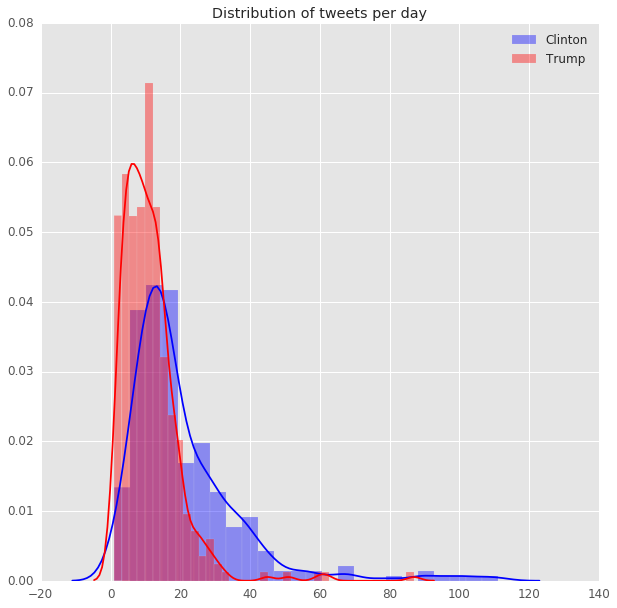

In [188]:
with sns.plotting_context("notebook", font_scale=1.2):
    fig, ax = plt.subplots(1,1, figsize = (10,10))
    sns.distplot(hc_tweets_per_day.values(), color='b', label='Clinton')
    sns.distplot(dt_tweets_per_day.values(), color='r', label='Trump')
    plt.title("Distribution of tweets per day")
    plt.legend()
plt.show()

Trump's tweets per day are less frequent, with a distribution heavily skewed towards the low end. 

## 3. Hashtag frequency Trump/Clinton  (2016) - (Simple demo of NLTK usage.)

In [281]:
#Import modules. We'll use the tweeter tokenizer

import nltk
from nltk.tokenize import TweetTokenizer

In [257]:
#Extract tweets from 2016 - Create mask for dataframe

dt_mask_2016 = ((df_dt.created_at >= datetime.datetime.strptime('2016-01-01',"%Y-%m-%d")) & (df_dt.created_at < datetime.datetime.strptime('2017-01-01',"%Y-%m-%d")))
hc_mask_2016 = ((df_hc.created_at >= datetime.datetime.strptime('2016-01-01',"%Y-%m-%d")) & (df_hc.created_at < datetime.datetime.strptime('2017-01-01',"%Y-%m-%d")))

In [258]:
#Use tokenizer to extract hashtags:

tknzr = TweetTokenizer()
dt_hastags = Counter([y.lower() for x in df_dt[dt_mask_2016].text for y in tknzr.tokenize(x) if (y[0] =='#' and len(y)>1)]) 
hc_hastags = Counter([y.lower() for x in df_hc[hc_mask_2016].text for y in tknzr.tokenize(x) if (y[0] =='#' and len(y)>1)]) 

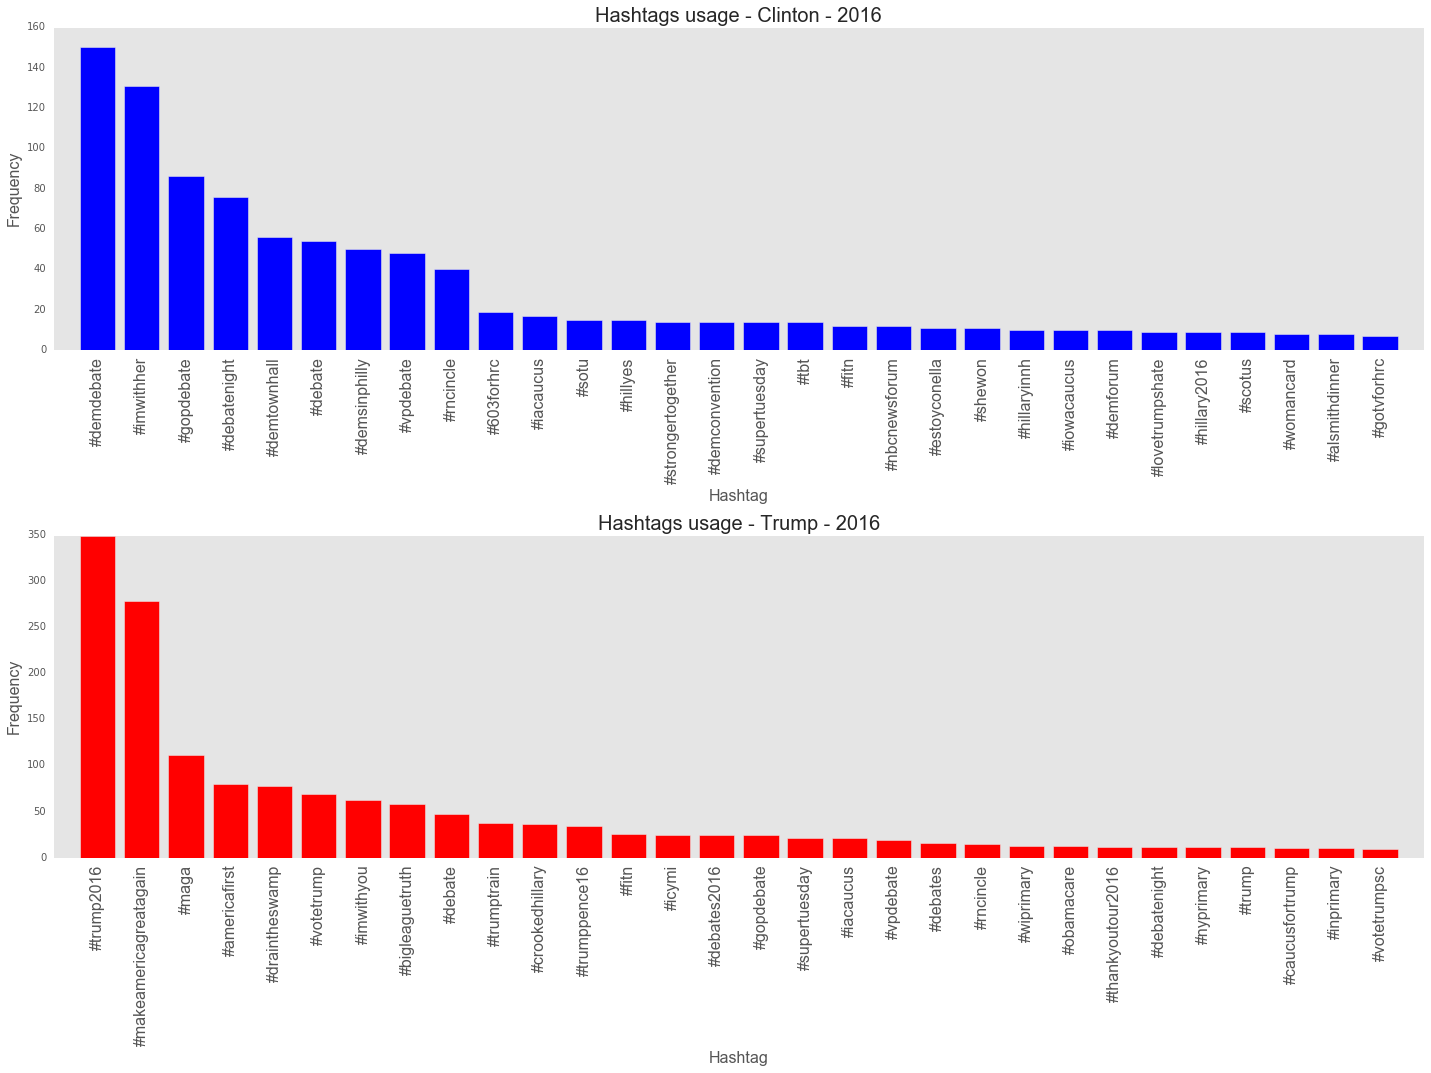

In [259]:
#Barplot of hashtags.

#plt.style.use('ggplot')
n_hast = 30
fig, axes = plt.subplots(2,1, figsize=(20,15))
axes[0].bar(range(n_hast), [x[1] for x in hc_hastags.most_common(n_hast)], width=0.8, align = 'center', color = 'b')
axes[0].set_xlabel('Hashtag', fontsize = 16)
axes[0].set_ylabel('Frequency', fontsize = 16)
axes[0].set_title(r'Hashtags usage - Clinton - 2016', fontsize = 20)
axes[0].set_xticks(range(n_hast))
axes[0].set_xticklabels([x[0] for x in hc_hastags.most_common(n_hast)], rotation = 90, fontsize = 16)
axes[0].set_xlim(left=-1)
plt.tight_layout()
axes[0].grid(False)
#axes[0].tight_layout()

axes[1].bar(range(n_hast), [x[1] for x in dt_hastags.most_common(n_hast)], width=0.8, align = 'center', color = 'r')
axes[1].set_xlabel('Hashtag', fontsize = 16)
axes[1].set_ylabel('Frequency', fontsize = 16)
axes[1].set_title(r'Hashtags usage - Trump - 2016', fontsize = 20)
axes[1].set_xticks(range(n_hast))
axes[1].set_xticklabels([x[0] for x in dt_hastags.most_common(n_hast)], rotation = 90, fontsize = 16)
axes[1].set_xlim(left=-1)
plt.tight_layout()
axes[1].grid(False)

plt.show()

## 4. Words used in tweets for either candidate - histogram

Again, use the tokenizer of the very good NLTK module:

In [260]:
#Use tokenizer to extract hashtags:

tknzr = TweetTokenizer()
dt_words = Counter([y.lower() for x in df_dt[dt_mask_2016].text for y in tknzr.tokenize(x) if (len(y)>1)]) 
hc_words = Counter([y.lower() for x in df_hc[hc_mask_2016].text for y in tknzr.tokenize(x) if (len(y)>1)]) 

In [263]:
dt_words.most_common(10) #Sample before filtering:

[(u'the', 2338),
 (u'to', 1505),
 (u'in', 1202),
 (u'and', 1200),
 (u'is', 1000),
 (u'you', 996),
 (u'of', 985),
 (u'will', 807),
 (u'for', 764),
 (u'on', 748)]

Not very good, lots of stop words and links, retweets, etc. This needs cleaning

In [264]:
#Import module for stopwords
from nltk.corpus import stopwords

In [269]:
def cleanupDoc(tweet):
    stopset = set(stopwords.words('english'))
    tokens = tknzr.tokenize(tweet) #use the twitter tokenizer
    cleanup = [token.lower() for token in tokens if token.lower() not in stopset and token.lower() != '...' and len(token)>2]
    cleanup2 = []
    for x in cleanup:
        if 'http' in x:
            x = 'LINK'
        elif '@' in x:
            x = 'RT'
        elif '#' in x:
            x = 'HASHTAG'
        else:
            pass
        cleanup2.append(x)
    return cleanup2

In [270]:
dt_tweets_2016 = [x for x in df_dt[dt_mask_2016].text]
temp = []
for tweet in dt_tweets_2016:
    temp.extend(cleanupDoc(tweet))
dt_tweets_count_2016 = Counter(temp)

In [280]:
dt_tweets_count_2016.most_common(20)

[('RT', 2580),
 ('LINK', 2090),
 ('HASHTAG', 2015),
 (u'thank', 641),
 (u'great', 578),
 (u'hillary', 460),
 (u'trump', 423),
 (u'clinton', 281),
 (u'people', 278),
 (u'america', 265),
 (u'new', 238),
 (u'crooked', 231),
 (u'make', 220),
 (u'get', 198),
 (u'cruz', 195),
 (u'vote', 180),
 (u'join', 177),
 (u'big', 164),
 (u'today', 146),
 (u'president', 143)]

In [272]:
hc_tweets_2016 = [x for x in df_hc[hc_mask_2016].text]
temp = []
for tweet in hc_tweets_2016:
    temp.extend(cleanupDoc(tweet))
hc_tweets_count_2016 = Counter(temp)

In [273]:
hc_tweets_count_2016.most_common(20)

[('LINK', 5119),
 ('RT', 3238),
 (u'hillary', 1488),
 ('HASHTAG', 1410),
 (u'trump', 1123),
 (u'donald', 601),
 (u'president', 545),
 (u'make', 412),
 (u'america', 365),
 (u'vote', 339),
 (u'one', 335),
 (u'people', 334),
 (u'need', 317),
 (u'women', 270),
 (u'families', 258),
 (u'get', 252),
 (u"it's", 229),
 (u'country', 223),
 (u'clinton', 220),
 (u'americans', 217)]

With this clean, tokenized version of the tweets, we get bar diagrams to check the most commonly used words by each:

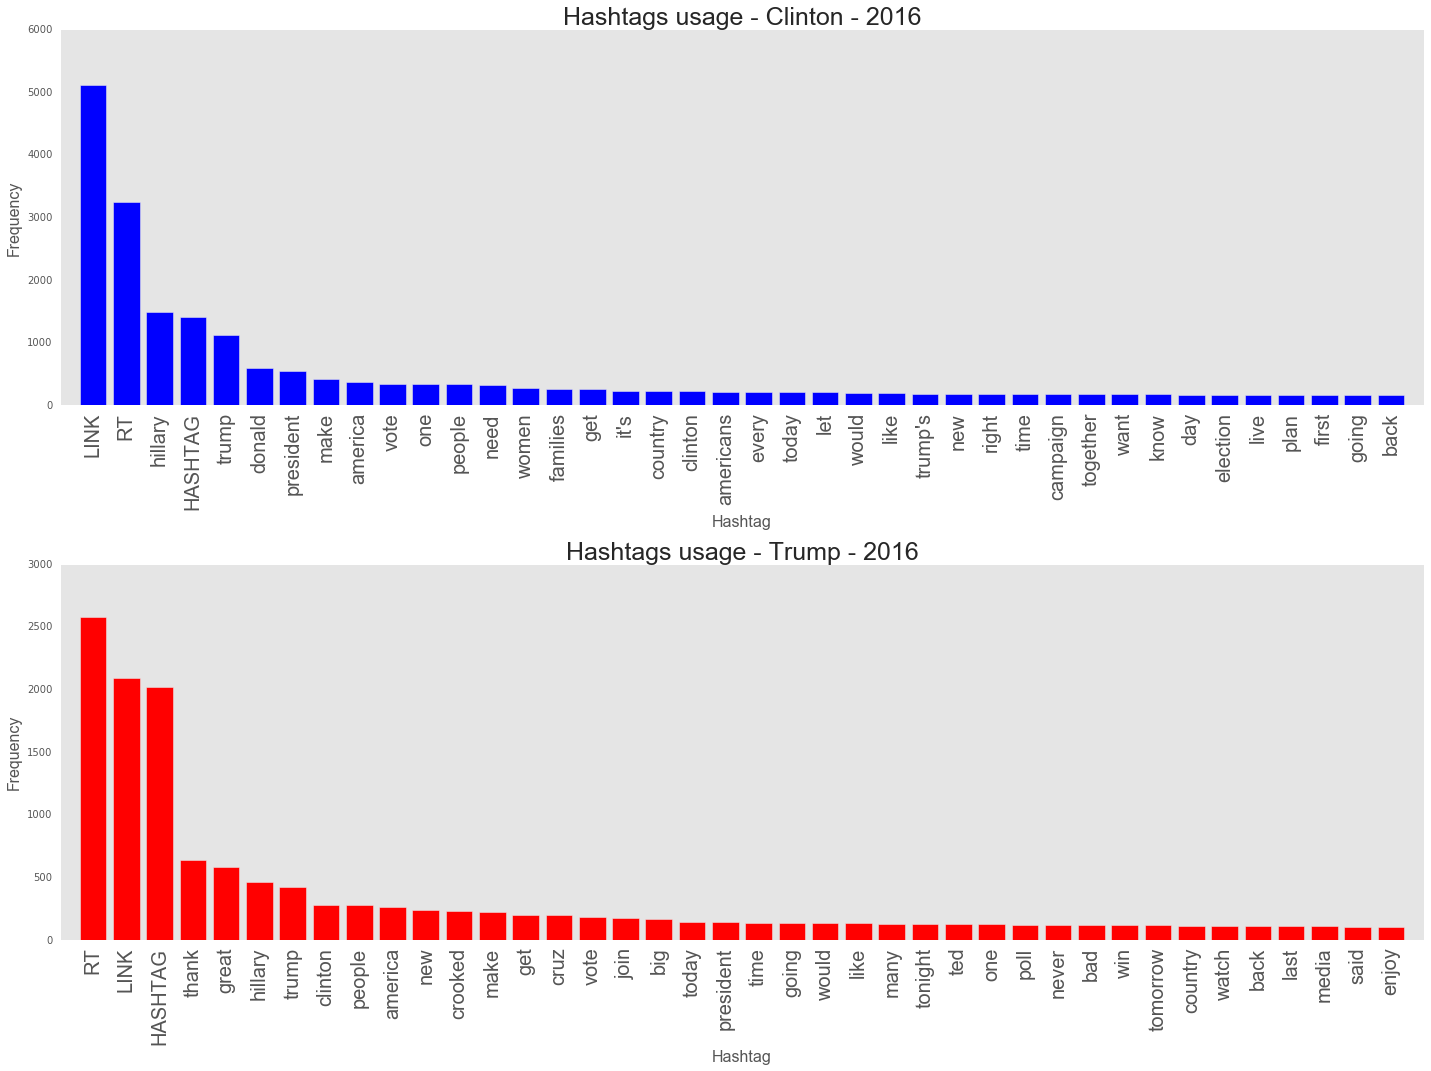

In [279]:
#Barplot of hashtags.

#plt.style.use('ggplot')
w_num = 40
fig, axes = plt.subplots(2,1, figsize=(20,15))
axes[0].bar(range(w_num), [x[1] for x in hc_tweets_count_2016.most_common(w_num)], width=0.8, align = 'center', color = 'b')
axes[0].set_xlabel('Hashtag', fontsize = 16)
axes[0].set_ylabel('Frequency', fontsize = 16)
axes[0].set_title(r'Hashtags usage - Clinton - 2016', fontsize = 25)
axes[0].set_xticks(range(w_num))
axes[0].set_xticklabels([x[0] for x in hc_tweets_count_2016.most_common(w_num)], rotation = 90, fontsize = 20)
axes[0].set_xlim(left=-1)
plt.tight_layout()
axes[0].grid(False)
#axes[0].tight_layout()

axes[1].bar(range(w_num), [x[1] for x in dt_tweets_count_2016.most_common(w_num)], width=0.8, align = 'center', color = 'r')
axes[1].set_xlabel('Hashtag', fontsize = 16)
axes[1].set_ylabel('Frequency', fontsize = 16)
axes[1].set_title(r'Hashtags usage - Trump - 2016', fontsize = 25)
axes[1].set_xticks(range(w_num))
axes[1].set_xticklabels([x[0] for x in dt_tweets_count_2016.most_common(w_num)], rotation = 90, fontsize = 20)
axes[1].set_xlim(left=-1)
plt.tight_layout()
axes[1].grid(False)

plt.show()

In [319]:
#Testing a porter stemmer... doesn't seem to work great here

from nltk.stem.porter import *

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

stemmer = PorterStemmer()
stemmed = stem_tokens(hc_tweets_count_2016.keys()[:20], stemmer)
count = Counter(stemmed)
print count.most_common(20)

[(u'aggress', 1), (u'fuera', 1), (u'elig', 1), (u'march', 1), (u'look', 1), (u'tire', 1), (u'woodi', 1), (u'four-year', 1), (u'rail', 1), (u'wednesday', 1), (u'igual', 1), (u'four', 1), (u'bring', 1), (u'lori', 1), (u'puls', 1), (u'waver', 1), (u'politician', 1), (u'broward', 1), (u'caryn', 1), (u'prize', 1)]


##  5. Predictive model. If we use a machine learning model, how certain are we of the author of the tweet?

In [292]:
#Import machine learning models
import numpy as np

from sklearn.utils import shuffle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm, grid_search
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.linear_model import SGDClassifier

In [293]:
#How many unique words per candidate?
print 'Clinton unique words: ' + str(len(hc_tweets_count_2016.keys()))
print 'Trump unique words: ' + str(len(dt_tweets_count_2016.keys()))

Clinton unique words: 7497
Trump unique words: 5906


In [294]:
#How many tweets do we have per person?
print 'clinton tweets= ' + str(len(hc_tweets_2016)) + ' trump tweets= ' + str(len(dt_tweets_2016))

clinton tweets= 6406 trump tweets= 4162


In [295]:
np.random.shuffle(hc_tweets_2016)
np.random.shuffle(dt_tweets_2016)

In [328]:
#Vectorizer for going from words -> numbers
vectorizer = TfidfVectorizer(tokenizer=cleanupDoc, min_df=5,
                                 max_df = 0.8,
                                 sublinear_tf=True,
                                 use_idf=True)

In [329]:
#Pick subset of data to train a predictive model with Trump/Clinton classes
clinton_train = hc_tweets_2016[:3200]; trump_train = dt_tweets_2016[:2100]

In [330]:
X_train = vectorizer.fit_transform(clinton_train+trump_train);
y_train = ['Clinton' for _ in range(len(clinton_train))] + ['Trump' for _ in range(len(trump_train))]

In [350]:
#Are we overfitting? - Maybe:
X_train.shape

(5300, 1662)

In [351]:
#Choose SVM/linear kernel as classifier
clf_linear = svm.SVC(kernel='linear')

In [332]:
clf_linear.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [333]:
#Define validation set
trump_val = dt_tweets_2016[2100:3000]; clinton_val = hc_tweets_2016[3200:4200];
y_val = ['Clinton' for _ in range(len(clinton_val))] + ['Trump' for _ in range(len(trump_val))]

In [334]:
pr_linear_val = clf_linear.predict(vectorizer.transform(clinton_val+trump_val))

In [335]:
#Evaluate predictive power in validating set
print classification_report(y_val, pr_linear_val)

             precision    recall  f1-score   support

    Clinton       0.83      0.92      0.88      1000
      Trump       0.90      0.79      0.84       900

avg / total       0.87      0.86      0.86      1900



Good predictive power! Let's check on the test set:

In [336]:
#Define test set for classifier
trump_test = dt_tweets_2016[3000:]; clinton_test = hc_tweets_2016[4200:]
y_test = ['Clinton' for _ in range(len(clinton_test))] + ['Trump' for _ in range(len(trump_test))]

In [337]:
pr_linear_test = clf_linear.predict(vectorizer.transform(clinton_test+trump_test))

In [338]:
#Evaluate predictive power in test set
print classification_report(y_test, pr_linear_test)

             precision    recall  f1-score   support

    Clinton       0.90      0.92      0.91      2206
      Trump       0.85      0.80      0.82      1162

avg / total       0.88      0.88      0.88      3368



Not bad!!! We're not overfitting...

### Now the fun part... We saw Clinton's/Trump's hashtags/words. The model is (reasonably) successful in predicting tweets authored by each candidate. What are the most relevant features to define a given class? (i.e., what does a tweet have to say to be more "Clintoney" or "Trumpey"?

In [339]:
#Function to extract most important features from classifier (by coeficient value)
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_list = np.array(clf.coef_.todense()).flatten()
    coefs_with_fns = sorted(zip(coefs_list, feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print "\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2)

### And... Clinton vs Trump speech (as classified by the model)

In [343]:
show_most_informative_features(vectorizer, clf_linear, 30)

	-3.5933	LINK           		5.2911	crooked        
	-3.3825	hillary        		3.6043	great          
	-2.0768	donald         		2.7091	thank          
	-1.9535	hillary's      		2.5224	HASHTAG        
	-1.8608	flint          		2.5047	media          
	-1.7365	climate        		2.4963	nice           
	-1.7198	families       		2.4059	bernie         
	-1.7096	dangerous      		2.3470	cruz           
	-1.6948	need           		2.2843	poll           
	-1.6775	ready          		2.2249	donaldtrump    
	-1.6662	tim            		2.0896	jeb            
	-1.6001	here's         		2.0726	enjoy          
	-1.5906	work           		2.0503	terrible       
	-1.5568	fear           		2.0046	clinton's      
	-1.5557	republicans    		2.0019	wow            
	-1.5466	volunteers     		1.9712	bad            
	-1.5084	woman          		1.9469	clinton        
	-1.4865	stronger       		1.8853	failed         
	-1.4767	sure           		1.7930	kaine          
	-1.4681	excited        		1.7755	sad            
	-1.4479	quit       

Can we improve the classifier? (Gridsearch)

In [347]:
param_grid_svc = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]
svr = svm.SVC()

In [348]:
clf = grid_search.GridSearchCV(estimator = svr, param_grid = param_grid_svc, cv = 3)
V_data = vectorizer.transform(hc_tweets_2016+dt_tweets_2016)
y_label = ['Clinton' for _ in range(len(hc_tweets_2016))] + ['Trump' for _ in range(len(dt_tweets_2016))]
clf.fit(V_data, y_label)

GridSearchCV(cv=3, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'kernel': ['linear'], 'C': [1, 10, 100, 1000]}, {'kernel': ['rbf'], 'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001]}],
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [36]:
clf.best_score_

0.86378685164748537